In [1]:
# imports
# local imports
import voxelmorph as vxm
import neurite as ne
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

import nbimporter
from functions import *


In [2]:
data_dir='/home/mahdi/Desktop/data_selection_D1'

In [4]:
#m=maxx(data_dir)
m=1584
train_generator = affine_generator(data_dir,100,m,.3)
in_sample, out_sample= next(train_generator)

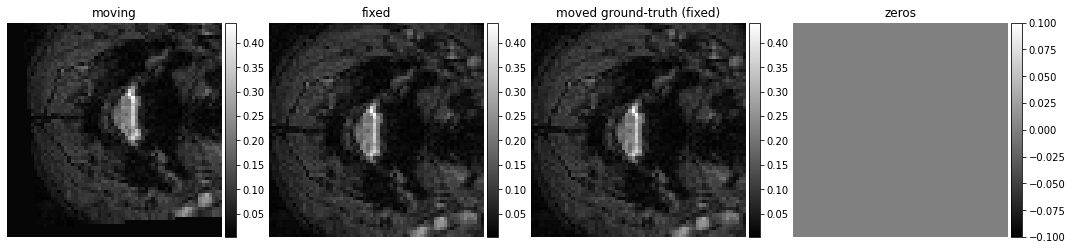

In [5]:
images = [img[99, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
#y[99]

In [6]:
in_sample[0].shape

(100, 64, 64, 1)

In [7]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
# data shape 64*64
s=in_sample[0].shape[1:3]
inshape = (*s, unet_input_features)

# configure unet features 
nb_features = [
    [64, 64, 64, 64],         # encoder features
    [64, 64, 64, 64, 64, 32,16]  # decoder features
]

# configure default input layers if an input model is not provided
#source = tf.keras.Input(shape=(*inshape, 1), name='source_input')
#target = tf.keras.Input(shape=(*inshape, 1), name='target_input')
#input_model = tf.keras.Model.unet(inputs=[source, target], outputs=[source, target])

# build model

In [8]:
# build model using VxmDense
inshape =s
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

In [9]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [10]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights, metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=5, verbose=1)

checkpoint = ModelCheckpoint('model_augment.h5', verbose=1, save_best_only=True)

In [12]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()




[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [13]:
with tf.device('/GPU:0'):
    nb_epochs = 100
    steps_per_epoch = 100
    hist = vxm_model.fit(train_generator,
                         epochs=nb_epochs,
                         steps_per_epoch=steps_per_epoch,
                         verbose=2,
                         callbacks=[checkpoint],
                         validation_data=val_generator(data_dir,1,1584,.3)
                        );

Epoch 1/100


KeyboardInterrupt: 